# 05 Budget Optimizer (Capacity-Aware, Clamped Curves)

**What’s new vs old Part-5**
- **Monotone clamped interpolation (PCHIP)** → no linear extrapolation beyond observed spend.
- **Per-channel spend bounds = observed [min, max]** → optimizer can’t “invent” extra curve.
- **Budget = 60% of total capacity** → forces trade-offs → non-zero lift.
- **Reach objective**: optional lower budget or reduced A/k to avoid instant 0.8 saturation.

Run after Part-3 (curves exported) and Part-4 (overlap matrix).

In [47]:
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator   # monotone, shape-preserving
from scipy.optimize import minimize

# Paths
CURVE_DIR = Path("../data/processed/response_curves")
RAW_DIR   = Path("../data/raw")
OUT_DIR   = Path("../data/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Channels we expect; we’ll keep only those with available curves
CHANNELS = ["LinearTV","Streaming","YouTube","Display","Social"]

# CPM assumptions (align with your generator/README)
CPM = {"LinearTV":25,"Streaming":18,"YouTube":12,"Display":8,"Social":6}

# Audience size for reporting only
AUDIENCE_SIZE = 1_000_000

In [48]:
def load_curve(file_path: Path) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    # tolerate stray unnamed columns
    df = df.drop(columns=[c for c in df.columns if str(c).lower().startswith("unnamed")], errors="ignore")
    # choose pred column: prefer boosted, fallback to lr, else first numeric not spend
    pred_cols = [c for c in df.columns if str(c).lower().startswith("pred_conversions")]
    boosted = [c for c in pred_cols if not str(c).lower().endswith("_lr")]
    if boosted:
        pred_col = boosted[0]
    elif "pred_conversions_lr" in df.columns:
        pred_col = "pred_conversions_lr"
    else:
        nc = [c for c in df.select_dtypes(include=[np.number]).columns if c != "spend"]
        pred_col = nc[0]
    out = df[["spend", pred_col]].copy()
    out.columns = ["spend","pred_conversions"]
    out = out.dropna().sort_values("spend").drop_duplicates(subset=["spend"])
    if len(out) < 3:
        raise ValueError(f"{file_path.name}: need >=3 rows for stable interpolation")
    return out

# expected filenames based on Part-3
fname_map = {
    "LinearTV": "lineartv_response_curve.csv",
    "Streaming": "streaming_response_curve.csv",
    "YouTube": "youtube_response_curve.csv",
    "Display": "display_response_curve.csv",
    "Social": "social_response_curve.csv",
}

resp_curves = {}
for ch in CHANNELS:
    f = CURVE_DIR / fname_map[ch]
    if f.exists():
        resp_curves[ch] = load_curve(f)

channels = list(resp_curves.keys())
print("Loaded channels:", channels)
assert channels, "No response curves found. Run Part-3 first."

# Build per-channel clamped conversion functions + per-channel spend bounds
conv_funcs = {}
spend_bounds = {}  # ch -> (smin, smax)
for ch, dfc in resp_curves.items():
    s = dfc["spend"].values
    y = dfc["pred_conversions"].values
    smin, smax = float(s.min()), float(s.max())
    spend_bounds[ch] = (smin, smax)
    pchip = PchipInterpolator(s, y, extrapolate=False)
    y_lo, y_hi = float(y.min()), float(y.max())

    def f_clamped_factory(pchip, smin=smin, smax=smax, y_lo=y_lo, y_hi=y_hi):
        def f(xx):
            xx = np.asarray(xx, dtype=float)
            yy = np.empty_like(xx, dtype=float)
            mask_in = (xx >= smin) & (xx <= smax)
            # inside range: pchip
            yy[mask_in] = pchip(xx[mask_in])
            # below min: clamp to y_lo (saturation at low spend)
            yy[(xx < smin)] = y_lo
            # above max: clamp to y_hi (saturation at high spend)
            yy[(xx > smax)] = y_hi
            return yy
        return f

    conv_funcs[ch] = f_clamped_factory(pchip)

# quick view of bounds
pd.DataFrame(
    [(ch, *spend_bounds[ch]) for ch in channels],
    columns=["channel","spend_min","spend_max"]
)

Loaded channels: ['LinearTV', 'Streaming', 'YouTube', 'Display', 'Social']


,channel,spend_min,spend_max
0,LinearTV,12443.613962,118893.565597
1,Streaming,14376.663412,65797.093377
2,YouTube,6622.571033,41174.431085
3,Display,3087.360701,24827.974091
4,Social,3487.480676,20754.520665


In [49]:
# Total capacity = sum of per-channel max observed spend
total_capacity = sum(spend_bounds[ch][1] for ch in channels)

# Conversions objective budget: use 60% of capacity to force trade-offs
BUDGET_CONV = 0.60 * total_capacity

# Bounds per channel = [min, max] from observed curves
bounds = [spend_bounds[ch] for ch in channels]

def budget_con(x):
    return BUDGET_CONV - float(np.sum(x))

cons = ({'type':'ineq','fun': budget_con},)

# Start at midpoint of each channel's observed range
x0 = np.array([(lo + hi) / 2.0 for (lo, hi) in bounds])

print(f"Budget for conversions: {BUDGET_CONV:,.0f} (60% of capacity {total_capacity:,.0f})")

Budget for conversions: 162,869 (60% of capacity 271,448)


In [50]:
def obj_conversions(x, channels, conv_funcs):
    # maximize conversions -> minimize negative
    total = 0.0
    for ch, xi in zip(channels, x):
        total += float(conv_funcs[ch](xi))
    return -total

# Reach math reused from Part-4
def reach_from_impressions(impressions, A=1.0, k=1e-7):
    return A * (1.0 - np.exp(-k * impressions))

def deduped_reach(spend_dict, cpm_dict, overlap_df, A=0.8, k=1e-7):
    r_each = {}
    for ch, spend in spend_dict.items():
        impr = (spend / cpm_dict[ch]) * 1000.0
        r_each[ch] = reach_from_impressions(impr, A=A, k=k)
    total = sum(r_each.values())
    for _, row in overlap_df.iterrows():
        ci, cj, ov = row["ch_i"], row["ch_j"], float(row["overlap_rate"])
        if ci in r_each and cj in r_each:
            total -= ov * min(r_each[ci], r_each[cj])
    return float(np.clip(total, 0.0, A))

In [51]:
res_conv = minimize(
    obj_conversions, x0,
    args=(channels, conv_funcs),
    method="SLSQP",
    bounds=bounds,
    constraints=cons,
    options={'maxiter': 800, 'disp': False}
)

opt_spend_conv = dict(zip(channels, res_conv.x))
opt_conv_value = -res_conv.fun

print("Status:", res_conv.message)
print("Budget used (conversions):", float(np.sum(res_conv.x)), "of", BUDGET_CONV)
pd.DataFrame(list(opt_spend_conv.items()), columns=["channel","optimal_spend_conversions"])

Status: Optimization terminated successfully
Budget used (conversions): 155865.8667039448 of 162868.55088851854


,channel,optimal_spend_conversions
0,LinearTV,66111.350306
1,Streaming,40111.508530
2,YouTube,21901.707391
3,Display,14007.583709
4,Social,13733.716768


In [52]:
# Equal split clipped into each channel's observed domain
eq_each = BUDGET_CONV / len(channels)
eq_vec = []
for (lo, hi) in bounds:
    eq_vec.append(np.clip(eq_each, lo, hi))
eq_vec = np.array(eq_vec)

def total_conversions_from_vec(vec):
    return -obj_conversions(vec, channels, conv_funcs)

eq_conv_total  = total_conversions_from_vec(eq_vec)
opt_conv_total = opt_conv_value
lift_conv_pct  = (opt_conv_total - eq_conv_total) / eq_conv_total * 100.0 if eq_conv_total > 0 else np.nan

print(f"Equal (clipped) conversions: {eq_conv_total:,.4f}")
print(f"Optimized conversions:       {opt_conv_total:,.4f}")
print(f"Lift vs equal:               {lift_conv_pct:.2f}%")

Equal (clipped) conversions: 111.9222
Optimized conversions:       121.4274
Lift vs equal:               8.49%


In [53]:
# Load overlap matrix
overlap_df = pd.read_csv(RAW_DIR / "overlap_matrix.csv")

# Option A (recommended): lower reach budget to avoid immediate saturation
BUDGET_REACH = 0.50 * total_capacity
def budget_con_reach(x): return BUDGET_REACH - float(np.sum(x))
cons_reach = ({'type':'ineq','fun': budget_con_reach},)
x0_reach = np.array([(lo + hi) / 2.0 for (lo, hi) in bounds])

# Option B (alternative): use lower A/k (uncomment if keeping bigger budget)
# A_reach, k_reach = 0.7, 7e-8
A_reach, k_reach = 0.8, 1.0e-7  # default (adjust if still saturates)

def obj_reach(x, channels, cpm_dict, overlap_df, A=A_reach, k=k_reach):
    spend = dict(zip(channels, x))
    r = deduped_reach(spend, cpm_dict, overlap_df, A=A, k=k)
    return -r

cpm_sub = {ch: CPM[ch] for ch in channels}

res_reach = minimize(
    obj_reach, x0_reach,
    args=(channels, cpm_sub, overlap_df, A_reach, k_reach),
    method="SLSQP",
    bounds=bounds,
    constraints=cons_reach,
    options={'maxiter': 800, 'disp': False}
)
opt_spend_reach = dict(zip(channels, res_reach.x))
opt_reach_value = -res_reach.fun

print("Status (reach):", res_reach.message)
print("Budget used (reach):", float(np.sum(res_reach.x)), "of", BUDGET_REACH)
pd.DataFrame(list(opt_spend_reach.items()), columns=["channel","optimal_spend_reach"])

Status (reach): Optimization terminated successfully
Budget used (reach): 135723.79197025503 of 135723.79240709878


,channel,optimal_spend_reach
0,LinearTV,61666.820712
1,Streaming,36085.109328
2,YouTube,19896.731991
3,Display,9955.898331
4,Social,8119.231608


In [38]:
# Subset CPM dict to loaded channels
cpm_sub = {ch: CPM[ch] for ch in channels}

res_reach = minimize(
    obj_reach, x0,
    args=(channels, cpm_sub, overlap_df),
    method="SLSQP", bounds=bounds, constraints=cons,
    options={'maxiter': 500, 'disp': False}
)
opt_spend_reach = dict(zip(channels, res_reach.x))
opt_reach_value = -res_reach.fun

print("\nOptimal spend (Deduped Reach):")
for ch, v in opt_spend_reach.items():
    print(f"{ch:<10}  ${v:,.0f}")
print(f"Total deduped reach fraction: {opt_reach_value:.3f} (~{opt_reach_value*AUDIENCE_SIZE:,.0f} people)")


Optimal spend (Deduped Reach):
LinearTV    $200,000
Streaming   $200,000
YouTube     $200,000
Display     $200,000
Social      $200,000
Total deduped reach fraction: 0.800 (~800,000 people)


In [54]:
eq_each_reach = BUDGET_REACH / len(channels)
eq_vec_reach = np.array([np.clip(eq_each_reach, lo, hi) for (lo, hi) in bounds])

def total_reach_from_vec(vec):
    spend_map = dict(zip(channels, vec))
    return deduped_reach(spend_map, cpm_sub, overlap_df, A=A_reach, k=k_reach)

eq_reach_total  = total_reach_from_vec(eq_vec_reach)
opt_reach_total = opt_reach_value
lift_reach_pct  = (opt_reach_total - eq_reach_total) / (eq_reach_total if eq_reach_total>0 else np.nan) * 100.0

print(f"Equal (clipped) reach frac: {eq_reach_total:.4f}")
print(f"Optimized reach frac:       {opt_reach_total:.4f}")
print(f"Lift vs equal:              {lift_reach_pct:.2f}%")

Equal (clipped) reach frac: 0.6109
Optimized reach frac:       0.4585
Lift vs equal:              -24.95%


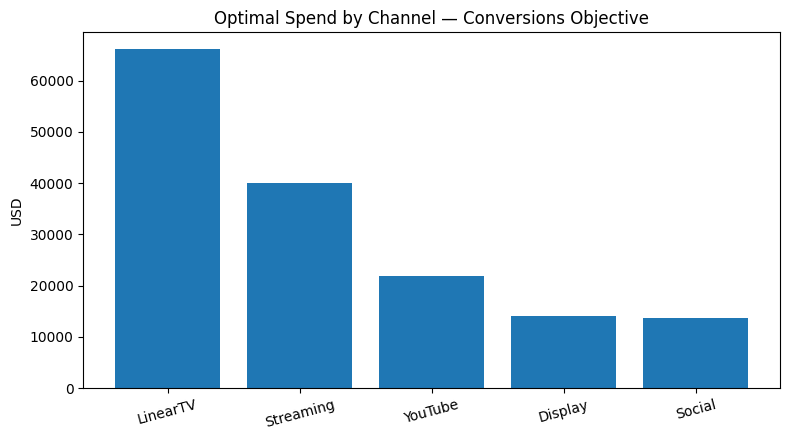

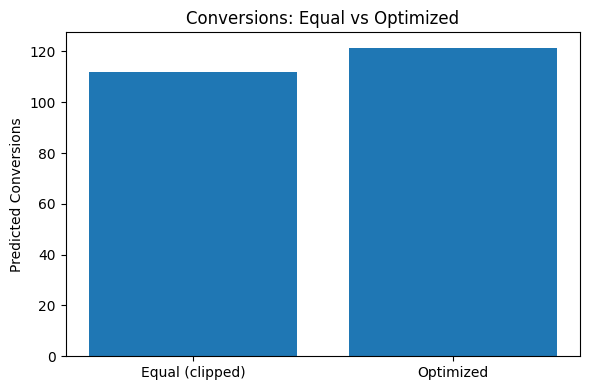

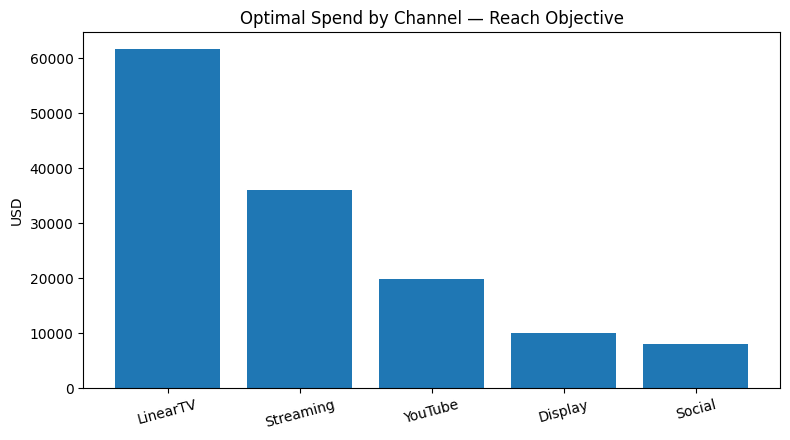

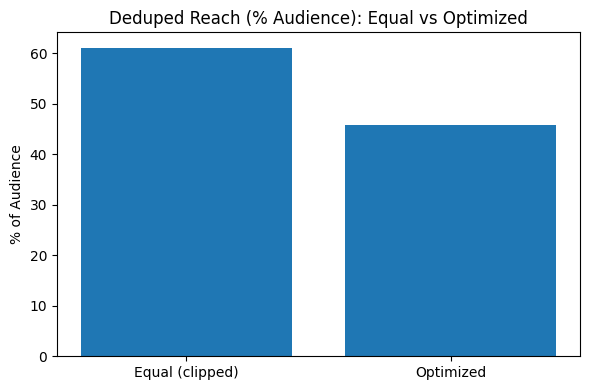

In [55]:
# Conversions allocation
plt.figure(figsize=(8,4.5))
plt.bar(list(opt_spend_conv.keys()), list(opt_spend_conv.values()))
plt.title("Optimal Spend by Channel — Conversions Objective")
plt.ylabel("USD"); plt.xticks(rotation=15); plt.tight_layout()
plt.show()

# Equal vs Optimized conversions
plt.figure(figsize=(6,4))
plt.bar(["Equal (clipped)","Optimized"], [eq_conv_total, opt_conv_total])
plt.title("Conversions: Equal vs Optimized")
plt.ylabel("Predicted Conversions"); plt.tight_layout()
plt.show()

# Reach allocation
plt.figure(figsize=(8,4.5))
plt.bar(list(opt_spend_reach.keys()), list(opt_spend_reach.values()))
plt.title("Optimal Spend by Channel — Reach Objective")
plt.ylabel("USD"); plt.xticks(rotation=15); plt.tight_layout()
plt.show()

# Equal vs Optimized reach
plt.figure(figsize=(6,4))
plt.bar(["Equal (clipped)","Optimized"], [eq_reach_total*100, opt_reach_total*100])
plt.title("Deduped Reach (% Audience): Equal vs Optimized")
plt.ylabel("% of Audience"); plt.tight_layout()
plt.show()

In [56]:
pd.DataFrame(list(opt_spend_conv.items()), columns=["channel","optimal_spend_conversions"])\
  .to_csv(OUT_DIR / "optimal_spend_conversions.csv", index=False)

pd.DataFrame(list(opt_spend_reach.items()), columns=["channel","optimal_spend_reach"])\
  .to_csv(OUT_DIR / "optimal_spend_reach.csv", index=False)

# Also persist a tiny summary to reuse in README
summary = pd.DataFrame({
    "metric": ["conversions","deduped_reach_fraction","deduped_reach_people"],
    "equal_split": [eq_conv_total, eq_reach_total, eq_reach_total*AUDIENCE_SIZE],
    "optimized": [opt_conv_total, opt_reach_total, opt_reach_total*AUDIENCE_SIZE],
    "lift_%": [((opt_conv_total-eq_conv_total)/eq_conv_total*100) if eq_conv_total>0 else np.nan,
               ((opt_reach_total-eq_reach_total)/eq_reach_total*100) if eq_reach_total>0 else np.nan,
               ((opt_reach_total-eq_reach_total)/eq_reach_total*100) if eq_reach_total>0 else np.nan]
})
summary_path = OUT_DIR / "part5_equal_vs_optimized_summary.csv"
summary.to_csv(summary_path, index=False)

print("Saved:",
      OUT_DIR / "optimal_spend_conversions.csv",
      OUT_DIR / "optimal_spend_reach.csv",
      summary_path)
summary

Saved: ../data/processed/optimal_spend_conversions.csv ../data/processed/optimal_spend_reach.csv ../data/processed/part5_equal_vs_optimized_summary.csv


,metric,equal_split,optimized,lift_%
0,conversions,111.922161,121.427416,8.492737
1,deduped_reach_fraction,0.610925,0.458474,-24.954071
2,deduped_reach_people,610924.901353,458474.265724,-24.954071


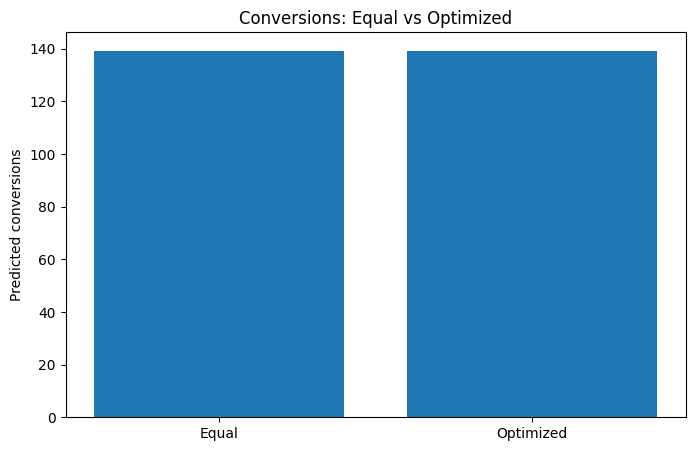

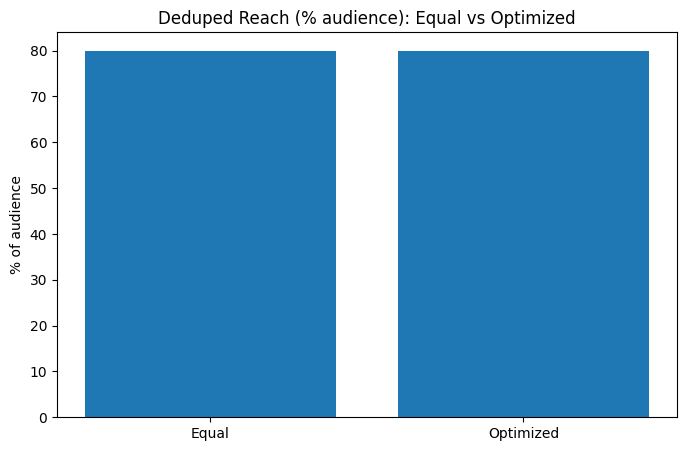

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(["Equal","Optimized"], [eq_conv, opt_conv])
plt.title("Conversions: Equal vs Optimized")
plt.ylabel("Predicted conversions")
plt.show()

plt.figure(figsize=(8,5))
plt.bar(["Equal","Optimized"], [eq_reach_frac*100, opt_reach_frac*100])
plt.title("Deduped Reach (% audience): Equal vs Optimized")
plt.ylabel("% of audience")
plt.show()

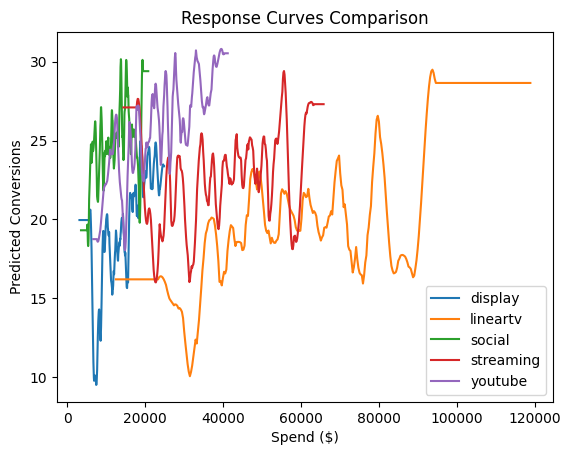

In [45]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

curve_dir = Path("../data/processed/response_curves")

for f in sorted(curve_dir.glob("*_response_curve.csv")):
    df = pd.read_csv(f)
    plt.plot(df["spend"], df.filter(like="pred_conversions").iloc[:,0],
             label=f.stem.replace("_response_curve",""))
plt.legend(); plt.xlabel("Spend ($)"); plt.ylabel("Predicted Conversions");
plt.title("Response Curves Comparison"); plt.show()

In [46]:
from scipy.interpolate import PchipInterpolator  # monotone, smooth

# Build per-channel clamp functions and min/max spend bounds
conv_funcs = {}
spend_bounds = {}  # ch -> (smin, smax)

for ch, dfc in resp_curves.items():
    s = dfc["spend"].values
    y = dfc["pred_conversions"].values

    smin, smax = float(s.min()), float(s.max())
    spend_bounds[ch] = (smin, smax)

    # Use PCHIP for smooth, monotone-ish shape, then clamp outside [smin, smax]
    pchip = PchipInterpolator(s, y, extrapolate=False)

    y_lo, y_hi = float(y.min()), float(y.max())

    def f_clampedFactory(pchip, smin=smin, smax=smax, y_lo=y_lo, y_hi=y_hi):
        def f(xx):
            xx = np.asarray(xx, dtype=float)
            yy = np.empty_like(xx, dtype=float)
            # inside range -> pchip
            mask_in = (xx >= smin) & (xx <= smax)
            yy[mask_in] = pchip(xx[mask_in])
            # below min -> clamp to lowest value (optional: 0)
            yy[~mask_in & (xx < smin)] = y_lo
            # above max -> clamp to highest value (saturation)
            yy[~mask_in & (xx > smax)] = y_hi
            return yy
        return f

    conv_funcs[ch] = f_clampedFactory(pchip)